## Подсчет PRS на новых данных 
Необходимо:
1. Извлечь данные фенотипов из таблички + z-score
2. Смерджить bed файлы в один
3. Посчитать PRS
4. Построить график https://drive.google.com/drive/folders/1Qfh55NF8Vs1-V_PNCQGOM0XweBprjGgB (с и d)

### 1. Извлечь данные фенотипов из таблички + z-score

In [2]:
import pandas as pd
from scipy.stats import zscore
from difflib import SequenceMatcher
import numpy as np

In [3]:
data = pd.read_excel('data/raw_pheno.xlsx')
data

,Наименование файла,ID,Направление,Вес,Рост,Полных лет,Пол
0,1112261.mm2.sortdup.bqsr.HaplotypeCaller.vcf.gz,E20B1112261,Здоровые,107.0,183.0,37.0,Мужской
1,1113645.mm2.sortdup.bqsr.hc.vcf.gz,E21B1113645,Здоровые,120.0,180.0,43.0,Мужской
2,1112646.mm2.sortdup.bqsr.HaplotypeCaller.vcf.gz,E20B1112646,Здоровые,93.0,165.0,62.0,Женский
3,E20B1113276.mm2.sortdup.bqsr.hc.vcf.gz,E20B1113276,Здоровые,75.0,176.0,28.0,Женский
4,E21B1113880.mm2.sortdup.bqsr.hc.vcf.gz,E21B1113880,Здоровые,47.0,158.0,37.0,Женский
...,...,...,...,...,...,...,...
11748,NNR00007496.mm2.sortdup.bqsr.hc.vcf.gz,NNR00007496,Здоровые,85.0,163.0,43.0,Женский
11749,NNR00007627.mm2.sortdup.bqsr.hc.vcf.gz,NNR00007627,Здоровые,87.0,181.0,47.0,Мужской
11750,NNR00007497.mm2.sortdup.bqsr.hc.vcf.gz,NNR00007497,Здоровые,70.0,164.0,42.0,Женский
11751,NNR00007628.mm2.sortdup.bqsr.hc.vcf.gz,NNR00007628,Здоровые,62.0,160.0,29.0,Женский


## Некоторые ID не соответствуют тем, что в .fam файле, так что нужно преобразовать и попытаться найти их

In [4]:
def find_longest_commen_end(string1, string2):
    count = 1
    while count < len(string1) and count < len(string2) and string1[-count] == string2[-count]:
        count += 1
    if count == 1:
        return ''
    return string1[-count:]

In [5]:
def seek_for_id(data_id, fam_id, exact_match=[]):
    closest_match_str = ''
    max_len = 0
    for true_id in fam_id:
        # Exact match
        if true_id == data_id:
            exact_match.append(true_id)
            return true_id
        match_str = find_longest_commen_end(true_id, data_id)
        if len(match_str) > max_len:
            max_len = len(match_str)
            closest_match_str = match_str
    # print(f'No exact id for "{data_id}", closest found is "{closest_match_str}"')
    return closest_match_str

In [6]:
fam_data = pd.read_csv('data/merged.fam', delimiter=' ', header=None)
fam_id = fam_data[0]

In [7]:
exact_match = []
data['clean_id'] = data['ID'].apply(lambda x: seek_for_id(str(x), fam_id, exact_match))

In [8]:
data[(data['clean_id'].duplicated(keep=False)) & (data['clean_id'].astype(str) != data['ID'].astype(str))][['clean_id', 'ID']]

,clean_id,ID
725,1111669,E20B1111669
1590,1112060,E20B1112060
1726,4030953,19B4030953
2134,4030965,19B4030965
3155,1112003,E20B1112003


In [9]:
not_taken_fam_id = list(set(fam_id) - set(exact_match))

In [10]:
hm = data[(data['clean_id'].duplicated(keep=False)) & (data['clean_id'].astype(str) != data['ID'].astype(str))]['ID'].apply(lambda x: seek_for_id(str(x), not_taken_fam_id))
hm

725     2669
1590    3060
1726    1953
2134    1965
3155    3003
Name: ID, dtype: object

In [11]:
# Лучше просто удалить
data.loc[data[(data['clean_id'].duplicated(keep=False)) & (data['clean_id'].astype(str) != data['ID'].astype(str))].index, 'clean_id'] = np.nan
data[(data['clean_id'].duplicated(keep=False)) & (data['clean_id'].astype(str) != data['ID'].astype(str))]['clean_id']
data.to_csv('data/clean_id.csv', sep='\t', index=False)

In [15]:
data.dropna(subset=['clean_id'], inplace=True)
data['ID'] = data['clean_id']
data.to_csv('data/raw_clean_id.tsv', sep='\t', index=False)


## Необходимо удалить родственников

In [70]:
not_related = pd.read_csv('data/merged.rel.fam', delimiter=' ', header=None)
not_related

,0,1,2,3,4,5
0,1111111,1111111,0,0,0,-9
1,1111112,1111112,0,0,0,-9
2,1111113,1111113,0,0,0,-9
3,1111114,1111114,0,0,0,-9
4,1111115,1111115,0,0,0,-9
...,...,...,...,...,...,...
8659,SGZ00000001,SGZ00000001,0,0,0,-9
8660,SGZ00000003,SGZ00000003,0,0,0,-9
8661,SGZ00000005,SGZ00000005,0,0,0,-9
8662,SGZ00000006,SGZ00000006,0,0,0,-9


In [72]:
data = data.merge(not_related, left_on=['ID'], right_on=[0], how='inner')


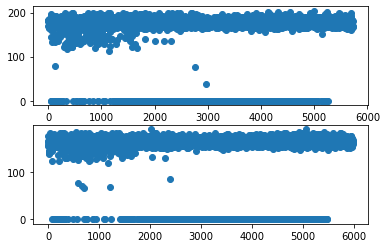

Empty DataFrame
Columns: [Наименование файла, ID, Направление, Вес, Рост, Полных лет, Пол]
Index: []


In [8]:
import matplotlib.pyplot as plt
import numpy as np
plt.subplot(211)
plt.scatter(np.arange(len(data[data['Пол'] == 'Мужской'])), data[data['Пол'] == 'Мужской']['Рост'])
plt.subplot(212)
plt.scatter(np.arange(len( data[data['Пол'] == 'Женский'])), data[data['Пол'] == 'Женский']['Рост'])
plt.show()
print(data[data['Рост'] > 500])

### Рост

In [9]:
pheno_male = data[data['Пол'] == 'Мужской'][['ID', 'Вес', 'Рост', 'Полных лет']].copy()
pheno_female = data[data['Пол'] == 'Женский'][['ID', 'Вес', 'Рост', 'Полных лет']].copy()
print(f'Female {len(pheno_female)} + male {len(pheno_male)} ({len(pheno_male) + len(pheno_female)} / {len(data)})')
print(f'{len(data) - (len(pheno_male) + len(pheno_female))} строк без данных о поле')
for col in pheno_male.columns:    
    print(f'Без колонки "{col}" у мужчин - {len(pheno_male[pheno_male[col].isna()])}')
    print(f'Без колонки "{col}" у женщин - {len(pheno_female[pheno_female[col].isna()])}')

print(data[data['Рост'] > 1000])

Female 5983 + male 5724 (11707 / 11753)
46 строк без данных о поле
Без колонки "ID" у мужчин - 0
Без колонки "ID" у женщин - 0
Без колонки "Вес" у мужчин - 0
Без колонки "Вес" у женщин - 0
Без колонки "Рост" у мужчин - 0
Без колонки "Рост" у женщин - 0
Без колонки "Полных лет" у мужчин - 0
Без колонки "Полных лет" у женщин - 0
Empty DataFrame
Columns: [Наименование файла, ID, Направление, Вес, Рост, Полных лет, Пол]
Index: []


In [75]:
pheno_male = pheno_male[(pheno_male['Полных лет'] > 20) & (pheno_male['Полных лет'] <= 60)]
pheno_female = pheno_female[(pheno_female['Полных лет'] > 20) & (pheno_female['Полных лет'] <= 60)]
pheno_male = pheno_male[(pheno_male['Рост'] > 140) & (pheno_male['Рост'] < 300)]
pheno_female = pheno_female[(pheno_female['Рост'] > 100) & (pheno_female['Рост'] < 300)]

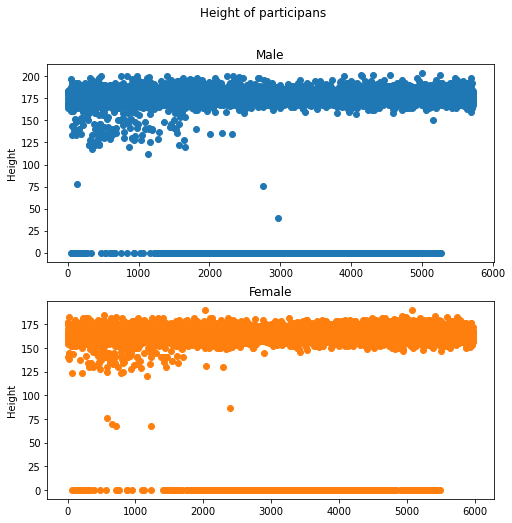

In [10]:
import matplotlib.pyplot as plt
import numpy as np
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
fig.suptitle('Height of participans')
ax1.scatter(np.arange(len(pheno_male)), pheno_male['Рост'], label='Male', c='#1f77b4')
ax1.set_title('Male')
ax1.set_ylabel('Height')
ax2.scatter(np.arange(len(pheno_female)), pheno_female['Рост'], label='Female', c='#ff7f0e')
ax2.set_title('Female')
ax2.set_ylabel('Height')
plt.show()

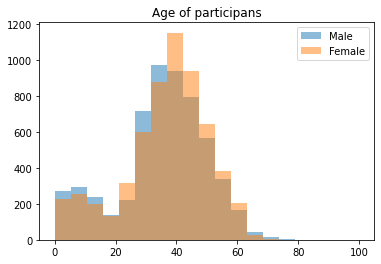

In [11]:
bins = np.linspace(0, 100, 20)

# Age histogram plot
plt.hist(pheno_male['Полных лет'], bins, alpha=0.5, label='Male')
plt.hist(pheno_female['Полных лет'], bins, alpha=0.5, label='Female')
plt.title('Age of participans')
plt.legend(loc='upper right')
plt.show()

In [78]:
pheno_male.to_csv('data/pheno_male.csv', sep='\t', index=False)
pheno_female.to_csv('data/pheno_female.csv', sep='\t', index=False)

In [79]:
pheno_male['FID'] = pheno_male['ID']
pheno_male['IID'] = pheno_male['ID']
pheno_female['FID'] = pheno_female['ID']
pheno_female['IID'] = pheno_female['ID']
pheno_male['zscore'] = pheno_male[['Рост']].apply(zscore)
pheno_female['zscore'] = pheno_female[['Рост']].apply(zscore)
pheno_male[['FID', 'IID', 'zscore']].to_csv('data/height/male.pheno', sep=' ', index=False)
pheno_female[['FID', 'IID', 'zscore']].to_csv('data/height/female.pheno', sep=' ', index=False)

In [80]:
pheno_all = pd.concat([pheno_male, pheno_female])
#pheno_all['zscore'] = pheno_all[['Рост']].apply(zscore)
pheno_all[['FID', 'IID', 'zscore']].to_csv('data/height/all.pheno', sep=' ', index=False)
pheno_all['AGE'] = pheno_all['Полных лет']
pheno_all[['FID', 'IID', 'AGE']].to_csv('data/height/all.cov', sep=' ', index=False)

### BMI

In [81]:
pheno_male = data[data['Пол'] == 'Мужской'][['ID', 'Вес', 'Рост', 'Полных лет']].copy()
pheno_female = data[data['Пол'] == 'Женский'][['ID', 'Вес', 'Рост', 'Полных лет']].copy()
pheno_male = pheno_male[(pheno_male['Полных лет'] > 20) & (pheno_male['Полных лет'] <= 60)]
pheno_female = pheno_female[(pheno_female['Полных лет'] > 20) & (pheno_female['Полных лет'] <= 60)]
pheno_male = pheno_male[(pheno_male['Рост'] > 140) & (pheno_male['Рост'] < 300)]
pheno_female = pheno_female[(pheno_female['Рост'] > 100) & (pheno_female['Рост'] < 300)]
pheno_female = pheno_female[(pheno_female['Вес'] > 10) & (pheno_female['Вес'] < 140)]
pheno_male = pheno_male[(pheno_male['Вес'] > 40) & (pheno_male['Вес'] < 160)]

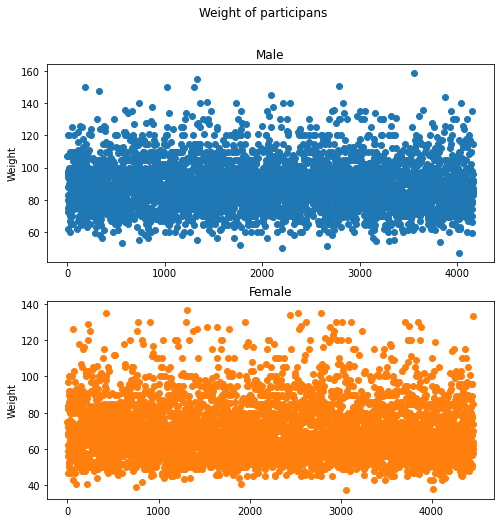

In [82]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
fig.suptitle('Weight of participans')
ax1.scatter(np.arange(len(pheno_male)), pheno_male['Вес'], label='Male', c='#1f77b4')
ax1.set_title('Male')
ax1.set_ylabel('Weight')
ax2.scatter(np.arange(len(pheno_female)), pheno_female['Вес'], label='Female', c='#ff7f0e')
ax2.set_title('Female')
ax2.set_ylabel('Weight')
plt.show()

In [83]:
pheno_male['BMI'] = pheno_male['Вес'] / ((pheno_male['Рост'] / 100)**2)
pheno_female['BMI'] = pheno_female['Вес'] / ((pheno_female['Рост'] / 100)**2)

In [84]:
pheno_male['FID'] = pheno_male['ID']
pheno_male['IID'] = pheno_male['ID']
pheno_female['FID'] = pheno_female['ID']
pheno_female['IID'] = pheno_female['ID']
pheno_male['zscore'] = pheno_male[['BMI']].apply(zscore)
pheno_female['zscore'] = pheno_female[['BMI']].apply(zscore)
pheno_male[['FID', 'IID', 'zscore']].to_csv('data/bmi/male.pheno', sep=' ', index=False)
pheno_female[['FID', 'IID', 'zscore']].to_csv('data/bmi/female.pheno', sep=' ', index=False)

In [85]:
pheno_all = pd.concat([pheno_male, pheno_female])
#pheno_all['zscore'] = pheno_all[['Рост']].apply(zscore)
pheno_all[['FID', 'IID', 'zscore']].to_csv('data/bmi/all.pheno', sep=' ', index=False)
pheno_all['AGE'] = pheno_all['Полных лет']
pheno_all[['FID', 'IID', 'AGE']].to_csv('data/bmi/all.cov', sep=' ', index=False)

Проблема - plink использует rsid, а не комбинацию позиции + alt + ref. 

А поскольку rsid могут быть например 1111 A->T,G, то есть включать в себя несколько вариантов, то это может вести к потере информации

**Что можно сделать?**
1. Склеить vcf, а потом перевести в bed
1. Работать с vcf

In [87]:
all_data = pd.read_csv('data/clean_id.csv', delimiter='\t')
all_data

,Наименование файла,ID,Направление,Вес,Рост,Полных лет,Пол,clean_id
0,1112261.mm2.sortdup.bqsr.HaplotypeCaller.vcf.gz,E20B1112261,Здоровые,107.0,183.0,37.0,Мужской,1112261
1,1113645.mm2.sortdup.bqsr.hc.vcf.gz,E21B1113645,Здоровые,120.0,180.0,43.0,Мужской,1113645
2,1112646.mm2.sortdup.bqsr.HaplotypeCaller.vcf.gz,E20B1112646,Здоровые,93.0,165.0,62.0,Женский,1112646
3,E20B1113276.mm2.sortdup.bqsr.hc.vcf.gz,E20B1113276,Здоровые,75.0,176.0,28.0,Женский,E20B1113276
4,E21B1113880.mm2.sortdup.bqsr.hc.vcf.gz,E21B1113880,Здоровые,47.0,158.0,37.0,Женский,E21B1113880
...,...,...,...,...,...,...,...,...
11748,NNR00007496.mm2.sortdup.bqsr.hc.vcf.gz,NNR00007496,Здоровые,85.0,163.0,43.0,Женский,NNR00007496
11749,NNR00007627.mm2.sortdup.bqsr.hc.vcf.gz,NNR00007627,Здоровые,87.0,181.0,47.0,Мужской,NNR00007627
11750,NNR00007497.mm2.sortdup.bqsr.hc.vcf.gz,NNR00007497,Здоровые,70.0,164.0,42.0,Женский,NNR00007497
11751,NNR00007628.mm2.sortdup.bqsr.hc.vcf.gz,NNR00007628,Здоровые,62.0,160.0,29.0,Женский,NNR00007628


In [ ]:
pheno_male = data[data['Пол'] == 'Мужской'][['ID', 'Вес', 'Рост', 'Полных лет']].copy()
pheno_female = data[data['Пол'] == 'Женский'][['ID', 'Вес', 'Рост', 'Полных лет']].copy()
pheno_male = pheno_male[(pheno_male['Полных лет'] > 20) & (pheno_male['Полных лет'] <= 60)]
pheno_female = pheno_female[(pheno_female['Полных лет'] > 20) & (pheno_female['Полных лет'] <= 60)]
pheno_male = pheno_male[(pheno_male['Рост'] > 140) & (pheno_male['Рост'] < 300)]
pheno_female = pheno_female[(pheno_female['Рост'] > 100) & (pheno_female['Рост'] < 300)]
pheno_female = pheno_female[(pheno_female['Вес'] > 10) & (pheno_female['Вес'] < 140)]
pheno_male = pheno_male[(pheno_male['Вес'] > 40) & (pheno_male['Вес'] < 160)]

In [ ]:
all_data[(all_data['Полных лет'] <= 20) | (all_data['Полных лет'] > 60)].to_csv('data/age_restricted.csv',sep='\t', index=False)

In [102]:
length_of_correct = len(all_data[(all_data['Полных лет'] > 20) & (all_data['Полных лет'] <= 60)])
correct = all_data[(all_data['Полных лет'] > 20) & (all_data['Полных лет'] <= 60)]
pheno_male = correct[correct['Пол'] == 'Мужской'][['ID', 'Вес', 'Рост', 'Полных лет', 'clean_id']].copy()
pheno_female = correct[correct['Пол'] == 'Женский'][['ID', 'Вес', 'Рост', 'Полных лет', 'clean_id']].copy()
pheno_male = pheno_male[(pheno_male['Рост'] > 140) & (pheno_male['Рост'] < 300)]
pheno_female = pheno_female[(pheno_female['Рост'] > 100) & (pheno_female['Рост'] < 300)]
pheno_all = pd.concat([pheno_male, pheno_female])
difference = correct[~correct.set_index(['clean_id']).index.isin(pheno_all.set_index(['clean_id']).index)]
print(len(difference))
difference.to_csv('data/height_restricted.csv',sep='\t', index=False)

477


In [103]:
pheno_female = pheno_female[(pheno_female['Вес'] > 10) & (pheno_female['Вес'] < 140)]
pheno_male = pheno_male[(pheno_male['Вес'] > 40) & (pheno_male['Вес'] < 160)]
pheno_all_weight = pd.concat([pheno_male, pheno_female])
difference = pheno_all[~pheno_all.set_index(['clean_id']).index.isin(pheno_all_weight.set_index(['clean_id']).index)]
print(len(difference))
difference.to_csv('data/weight_restricted.csv',sep='\t', index=False)

37


In [108]:
not_related = pd.read_csv('data/merged.rel.fam', delimiter=' ', header=None)
difference = pheno_all_weight[~pheno_all_weight.set_index(['clean_id']).index.isin(not_related.set_index([0]).index)]
print(len(difference))
difference.to_csv('data/relative_restricted.csv',sep='\t', index=False)

601
